# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

## This is a copy of the actual EPM model that is designed solely to figure out how to get the watershed geoJSON file to fit onto a model grid with the appropriate Coordinate Reference System

In [1]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from datetime import datetime #for dealing with datetime objects
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
import geopandas as gpd #For importing shapefiles
from shapely.geometry import LineString # For finding polygon boundaries
from shapely.validation import make_valid #For fixing polygon errors from imported data

## Load External Data

Import the Sinkhole and Spring Data  
Import Watershed data  
Import Bear Creek Location Data

In [2]:
#Load the Watershed Extent data from USGS StreamStats
geoJSON = './data/WS_1.geojson'
watershed = gpd.read_file(geoJSON)

projected_crs = 'EPSG:32615'
watershed = watershed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
watershed_types = watershed.geometry.type.unique()
print(watershed_types)

#Generate a Polygon object from the watershed geoJSON
wsPolygon = watershed[watershed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
wsPolygon.loc[:,'geometry'] = wsPolygon['geometry'].apply(make_valid)
print(f'The polygon is Valid: {wsPolygon.is_valid}')
wsPolygon = wsPolygon.explode(index_parts=True)

#get the bounding box for the watershed polygon
bounds = wsPolygon.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Import the karst feature data (UTME, UTMN, elevation data)
f = pl.Path('./data/karst_features.csv')
karst_df = pd.read_csv(f)
karst_df = karst_df.set_index("ID") #Set the index for the karst dataframe to the feature name
karst_df['Elevation_m'] = karst_df['Elevation_ft'] * 0.3048 # create a new col. with the m elevation

#Import the creek data shapefile
creeks = gpd.read_file('./data/creeks_geoJSON.geojson')
creeks = creeks.to_crs(wsPolygon.crs) #Set the coordinate reference system for the shapefile
creeks = gpd.clip(creeks, wsPolygon) #Mask out all the shapefile data that is not inside of the wsPolygon

['Point' 'Polygon']
The polygon is Valid: 1    True
dtype: bool
min x: 557184.4037729454, min y: 4867185.873280004, max x: 561054.4043688355, max y: 4870485.873787433


In [84]:
#Create access Functions for different data types

#Get karst feature data from karst_df
def get_karst_data(ID):
    return karst_df.loc[ID].to_dict()

#Get DEM elevation data for a karst feature point
def get_cell_elev(ID):
    k_feat = get_karst_data(ID)
    i, j = sg.intersect(k_feat['UTME'], k_feat['UTMN'])
    elev = dem_grid[i,j]
    #print(f'Feature ID: {ID},row: {i}, col: {j}, DEM_elev: {elev} ')
    return elev, i, j

#Get elevations, cell i, j intersections for the structured grid with the creek
def get_creek_cells(creek, conductance = 10):
    river_cells = [] #Initialize a list of the cells where the creek meets the sg
    #iterate over the line segment of the creek shapefile
    for line in creek.geometry:
        for coord in list(line.coords): #Access each coordinate in the line for the shapefile
            x , y = coord
            i, j = sg.intersect(x,y)
            # Check if the cell is in the active domain
            if idomain[0, i, j] == 1:  # Assuming idomain is 3D (nlay, nrow, ncol)
                elev = dem_grid[i, j]
                river_cells.append((0, i, j, elev, conductance))
    return river_cells

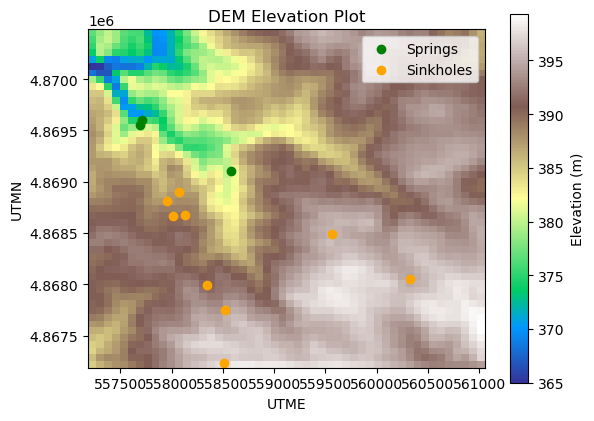

Current UTM Boundary: 557184.4037729454
Current UTM Boundary: 4867185.873280004
Current UTM Boundary: 561054.4043688355
Current UTM Boundary: 4870485.873787433


In [4]:
#Import the DEM data

ncol = 50 # number of grid columns in the model (Needs to be the same for the DEM grid conversion and for the model)
nrow = 50 # number of grid rows in the model (Needs to be the same for the DEM grid conversion and for the model)

#Isolate the spring and sinkhole coordinates for plotting on DEM
springs = karst_df[karst_df['Type'] == 'spring' ] #get springs
sinkholes = karst_df[karst_df['Type'] == 'sink' ] #get sinkholes

with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    #define the window of useful data(in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)#get window boundaries to confirm they are correct
    
    #convert all of the data to a grid so it can be used with the MODFLOW model
    width = ncol#set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling= rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)

#Plot DEM as a colorplot to evaluate all of the values and establish the value range and units
plt.imshow(dem_grid, cmap='terrain', extent=[extent[0], extent[2], extent[1], extent[3]])
plt.colorbar(label='Elevation (m)')
plt.xlabel('UTME')
plt.ylabel('UTMN')
plt.title('DEM Elevation Plot')
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs') #Plot spring locations
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes') #Plot sinkhole locations
plt.legend()
plt.show()

#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')

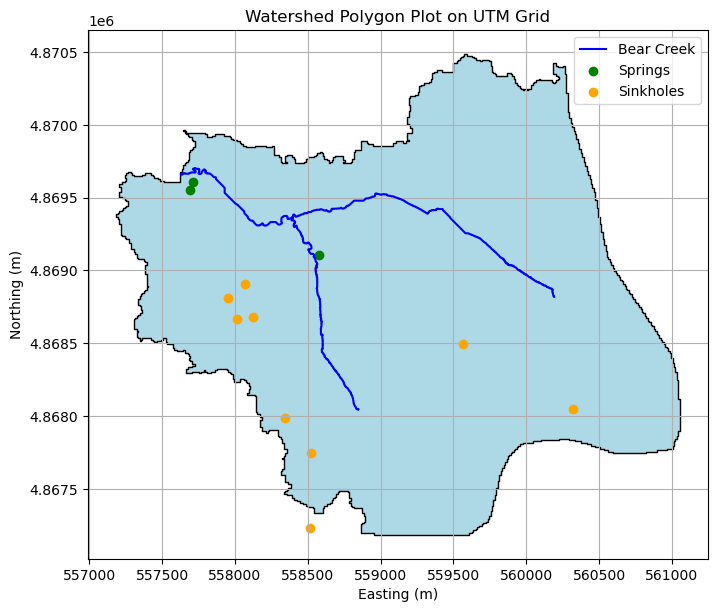

In [5]:
# Plot the polygon using the correct CRS to ensure that the bounds are in the right coordinate system and that the polygon looks correct
fig, ax = plt.subplots(figsize=(8, 8))
wsPolygon.plot(ax=ax, color='lightblue', edgecolor='black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.legend()

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [6]:
#Set all of the relevant input parameters for the grid construction
Lx = bounds[2] - bounds[0] #Use the bounding box of the model to be the length along the x axis
Ly = bounds[3] - bounds[1] #Use the bounding box of the model to be the length along the y axis
nlay = 3 #stewartville/Prosser, BPP, Cummingsville
#nrow = 100 #set above in the DEM grid 
#ncol = 100 #set above in the DEM grid
delr = Lx / ncol * np.ones(ncol, dtype=float)
delc = Ly / nrow * np.ones(nrow, dtype=float)
top = dem_grid #elevation of the singular layer top
botm_layers = [372.161, 371.856, 352.044] #m above sea lvl (bottom Stewartville + Prosser, bottom BPP, bottom Cummingsville)
botm = np.ones((nlay, nrow, ncol), dtype=float) #set up the bottom arrays
#assign the elevations to the bottom arrays for the grid
for k in range(nlay):
    botm[k] = botm_layers[k]

In [7]:
# Generate the model grid in flopy
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds[0],
    yoff=bounds[1],
    crs= 'EPSG:32615'
)

In [86]:
#Get coordinates for sinkholes and springs in terms of i, j on the modelgrid

#Get all of the coordinates for the sinkholes
sinkhole_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'sink'])):
    df = karst_df[karst_df['Type'] == 'sink']
    sinkhole = df.iloc[i]
    elev, row, col = get_cell_elev(sinkhole.name)
    sinkhole_cells.append((sinkhole.name, elev, row, col))

#get all of the coordinates for the springs (NOT including Bear Spring)
spring_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'spring'])):
    df = karst_df[karst_df['Type'] == 'spring']
    spring = df.iloc[i]
    elev, row, col = get_cell_elev(spring.name)
    spring_cells.append((spring.name, elev, row, col))

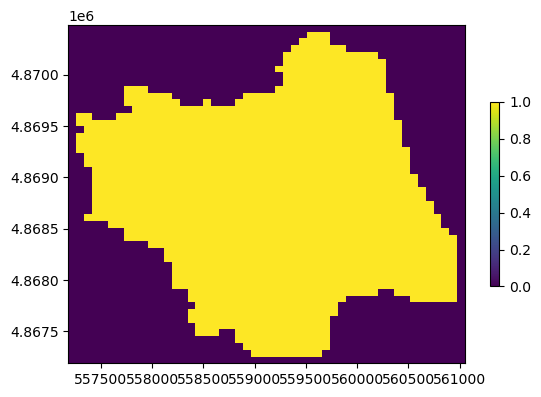

In [8]:
#create an idomain indicator array to activate and deactivate cells
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

#create a flopy grid intersect object to use with the idomain array
gi = flopy.utils.GridIntersect(sg)

#extract the raw Polygon from the GeoDataFrame object wsPolygon
domain = wsPolygon.geometry.values[0]

#inside the domain polygon (watershed polygon)
ixp = gi.intersect(domain)
for i, j in ixp["cellids"]:
    idomain[:, i, j] = 1
    
#Use the idomain array to deal with areas where the bot. elevation exceeeds surface
for k in range(nlay): #iterate through the layers
    for i in range(nrow): #iterate across the rows
        for j in range(ncol): #iterate across the columns
            if botm[k, i, j] >= top[i, j]:
                idomain[k, i, j] = 0 #turn off any cells with botm elev > top elev
    
#touching the domain polygon (idomain = 2) (boundary cells)
ls = LineString([p for p in domain.exterior.coords])
ixl = gi.intersect(ls)
for i, j in ixl["cellids"]:
    # Set boundary cells to 2, but only if they are already active (i.e., thickness > 0)
    if np.all(idomain[:, i, j] == 1):  # only set to 2 if not already deactivated
        idomain[:, i, j] = 0
    
#all cells not in the domain or touching it are assigned an idomain value of 0
pmv = flopy.plot.PlotMapView(modelgrid=sg)
cb = pmv.plot_array(idomain)
plt.colorbar(cb, shrink=0.5)

## Assign Aquifer Properties

In [9]:
#Assign hydraulic conductivity (K) values for each of the layers

KhSP = 60 * 0.3048
KhBPP = 200 * 0.3048
Khcummingsville = 10 * 0.3048 
KvSP = 0.6 * 0.3048
KvBPP = 2 * 0.3048
KvCummingsville = 0.0001 * 0.3048

Kv = [KvSP, KvBPP, KvCummingsville] #m/day
Kh = [KvSP, KvBPP, KvCummingsville] #m/day

## Build and Run the Simulation

In [10]:
ws = './sim-01_EPM_wsgrid'
name = 'EPM_wsgrid'

#generate the simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    sim_ws=ws,
    exe_name='mf6',
    version = 'mf6'
)

#Build the time inputs
tuni = 'DAYS'
nper = 1 #The number of stress periods
nstp = 1 #The number of timesteps
perlen = 1.0 #The length of each stress period
tsmult = 1.0 #length of successive timesteps

#Generate the tdis object (starting w/ tdis set up for steady state model)
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname = "tdis",
    time_units = tuni,
    nper = nper,
    perioddata = [(perlen, nstp, tsmult)]
)

#Create the IMS package (iterative model solver)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    inner_dvclose = 0.0001,
    outer_dvclose = 0.0001,
    linear_acceleration="BICGSTAB",
    complexity = "SIMPLE"
)

#Create the groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname = name,
    save_flows = True,
    newtonoptions = 'NEWTON UNDER_RELAXATION'
)

#create the discretization package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = delr,
    delc = delc,
    top = top,
    botm = botm,
    xorigin = extent[0],
    yorigin = extent[1],
    idomain = idomain
)

#Set up the drain which will represent Bear Spring and the river
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
kBS = 1 #layer of Bear Spring (layer 1, connected to the BPP)
BS_conductance = KhBPP #set the conductance of the spring = to the BPP conductivity
BS_drain = [(kBS, iBS, jBS, BSelev, BS_conductance)] #build the Bear Spring drain list
river_drain = get_creek_cells(creeks) #get the list of all the drain cell loations, elevs, conductances

drnspd = BS_drain + river_drain #combined list of the drain data to pass into MODFLOW DRN package ##I AM STILL HAVING ISSUES WITH THE river_drain!!

#Drain package
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data = drnspd,
    save_flows = True
)

#initial conditions (estimated water table elevation)
wtElev = top - 15 #setting the wt elevation below the surface everywhere to start
strt = wtElev * np.ones((nlay ,nrow , ncol))
strt[idomain == 0] = 0 #ensure the strt array is only assigned to active cells (idomain == 1))
ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)

#node property flow package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k = Kh,
    k33 = Kv,
    icelltype = 0,
    save_specific_discharge = True
)

#No storage package as the model is in steady state, thus storage is constant
# For now, set the boundary cells (idomain=2) to constant head BC
#Set up the constant head boundary condition array (assign to cells where idomain == 2)
chdspd = []
for k in range(nlay):
    for i in range(nrow):
        for j in range(ncol):
            if idomain[k, i, j] == 2:  # boundary cells
                chdspd.append([(k, i, j), top[i, j]])
                
#Assign constant head package (CHD)
#chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data = chdspd)

#set the recharge condition to be a very small amount of recharge
#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge = 0.0001)

#set the output control module for ease of access later
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

Feature ID: 55A00406,row: 13, col: 6, DEM_elev: 374.423583984375 


In [11]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_wsgrid...
    writing model name file...
    writing package dis...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 785 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package oc...


In [12]:
#run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 10/18/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 18 2024 02:59:03 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that nei

(True, [])

## Post Process the model outputs

In [13]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

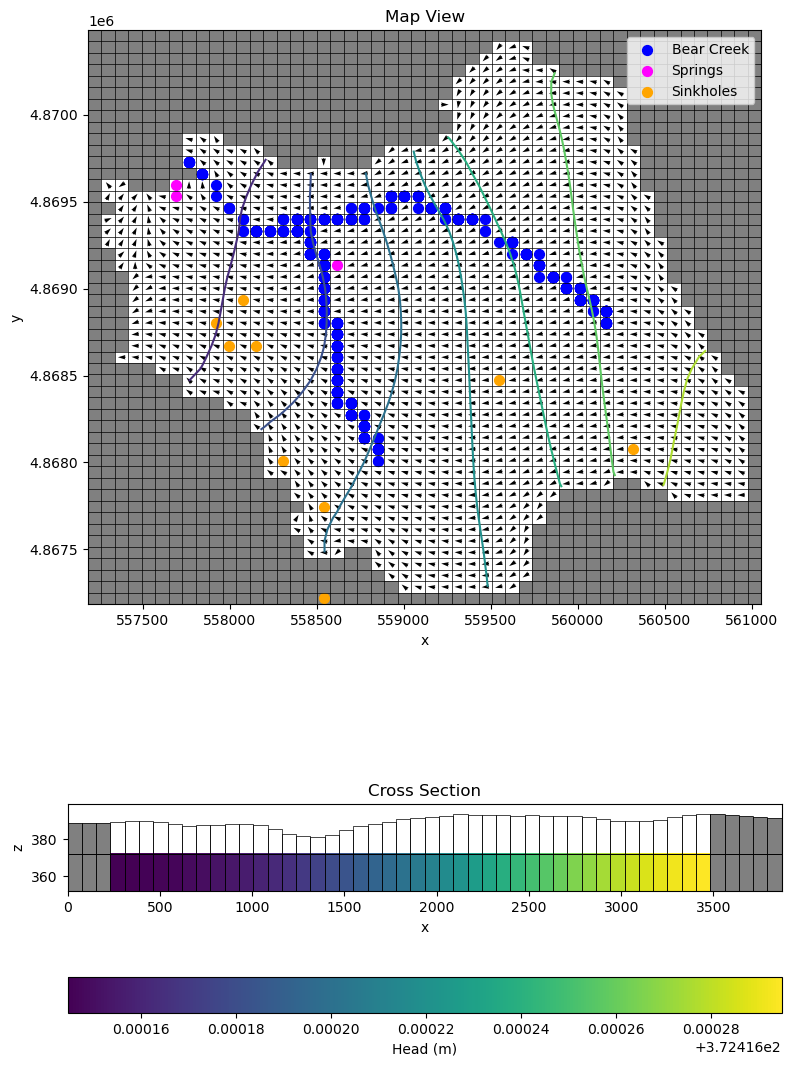

In [91]:
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0] 
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
#pmv.plot_bc(ftype="CHD") 
#cb = pmv.plot_array(head)
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.5)
pmv.contour_array(head)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
#ax.scatter(springs['UTME'], springs['UTMN'], color = 'magenta', label='Springs') #This plots raw UTME and UTMN, not in cells
#ax.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes') #This plots raw UTME and UTMN, not in cells
#plt.colorbar(cb, label = "Head (m)")

# Get cell locations for Bear Creek
river_cells = [(cell[1], cell[2]) for cell in river_drain]  # Extract row and column indices from river_drain
river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the Sinkholes in the model
#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

#Plot the creek, spring, and sinkhole cells on the map
ax.scatter(river_x, river_y, color='blue', s=50, label = 'Bear Creek') # PLot the river_drain cells
ax.scatter(spring_x, spring_y, color='magenta', s=50, label = 'Springs') # PLot the spring_drain cells
ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=50, label = 'Sinkholes')
ax.legend()

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow/2)})
pxs.plot_inactive(color_noflow="gray")
#pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
cb = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
plt.tight_layout()